In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

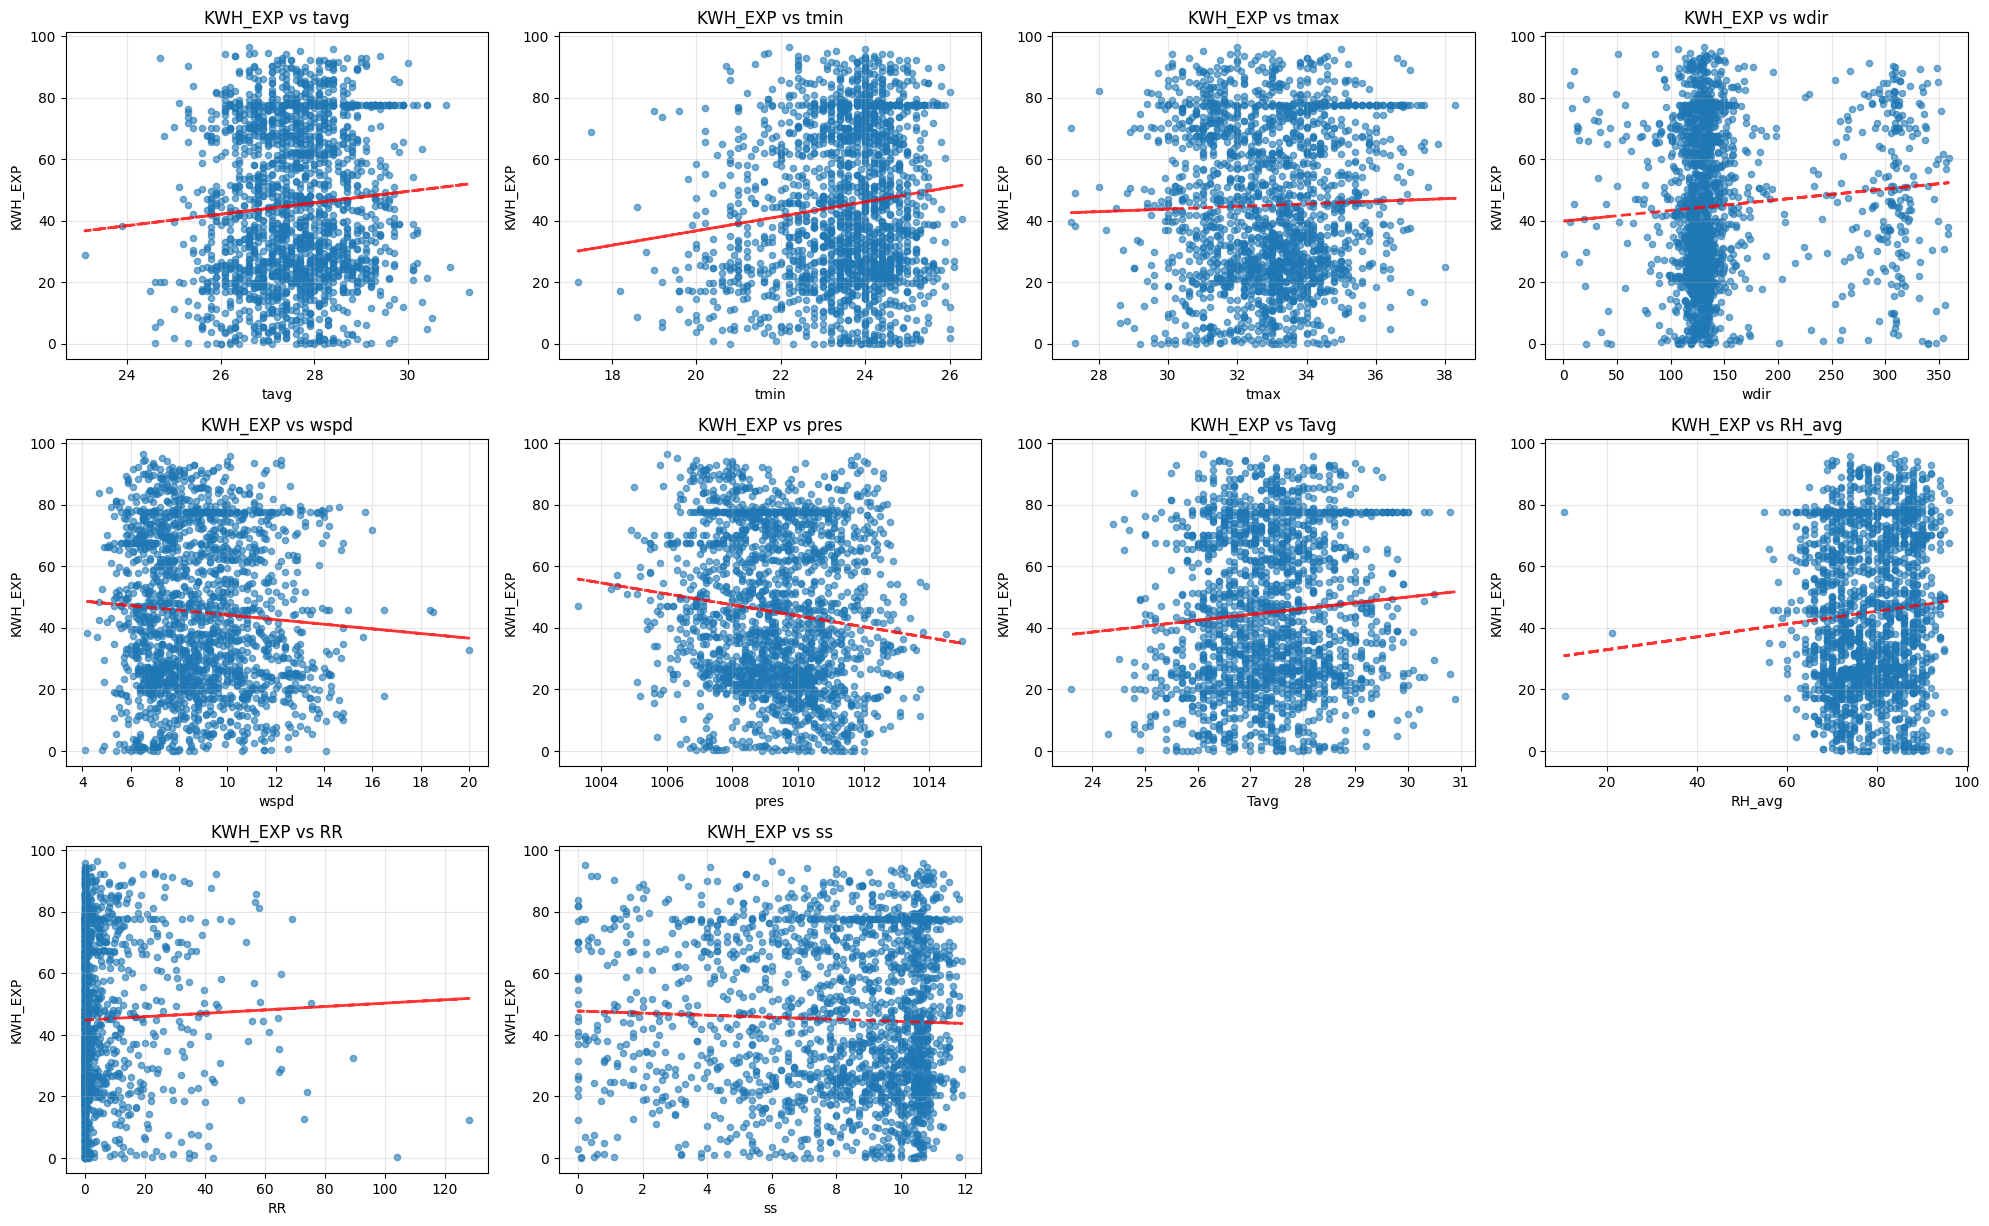

In [ ]:
df = pd.read_csv('../processed/aa_442400146024_engineered.csv')
target_col = 'KWH_EXP'
feature_cols = ['tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres', 
                'Tavg', 'RH_avg', 'RR', 'ss']



plt.figure(figsize=(20, 16))

for i, feature in enumerate(feature_cols):
    plt.subplot(4, 4, i+1)
    
    mask = ~(df[feature].isna() | df[target_col].isna())
    x_clean = df[feature][mask]
    y_clean = df[target_col][mask]
    
    plt.scatter(x_clean, y_clean, alpha=0.6, s=20)
    plt.xlabel(feature)
    plt.ylabel('KWH_EXP')
    plt.title(f'KWH_EXP vs {feature}')
    
    if len(x_clean) > 1:
        z = np.polyfit(x_clean, y_clean, 1)
        p = np.poly1d(z)
        plt.plot(x_clean, p(x_clean), "r--", alpha=0.8, linewidth=2)
    
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
correlation_data = df[feature_cols + [target_col]].corr()

kwh_correlations = correlation_data[target_col].drop(target_col).abs().sort_values(ascending=False)

print("=== KORELASI PEARSON DENGAN KWH_EXP ===")
print("(Diurutkan berdasarkan kekuatan korelasi)\n")
for feature, corr in kwh_correlations.items():
    strength = "Sangat Kuat" if corr > 0.8 else "Kuat" if corr > 0.6 else "Sedang" if corr > 0.4 else "Lemah" if corr > 0.2 else "Sangat Lemah"
    actual_corr = correlation_data.loc[feature, target_col]  # Get actual correlation (with sign)
    print(f"{feature:12}: r = {actual_corr:7.4f} (|r| = {corr:.4f}) - {strength}")

=== KORELASI PEARSON DENGAN KWH_EXP ===
(Diurutkan berdasarkan kekuatan korelasi)

tmin        : r =  0.1211 (|r| = 0.1211) - Sangat Lemah
pres        : r = -0.1204 (|r| = 0.1204) - Sangat Lemah
wdir        : r =  0.0856 (|r| = 0.0856) - Sangat Lemah
Tavg        : r =  0.0823 (|r| = 0.0823) - Sangat Lemah
tavg        : r =  0.0789 (|r| = 0.0789) - Sangat Lemah
RH_avg      : r =  0.0697 (|r| = 0.0697) - Sangat Lemah
wspd        : r = -0.0655 (|r| = 0.0655) - Sangat Lemah
ss          : r = -0.0391 (|r| = 0.0391) - Sangat Lemah
tmax        : r =  0.0286 (|r| = 0.0286) - Sangat Lemah
RR          : r =  0.0233 (|r| = 0.0233) - Sangat Lemah


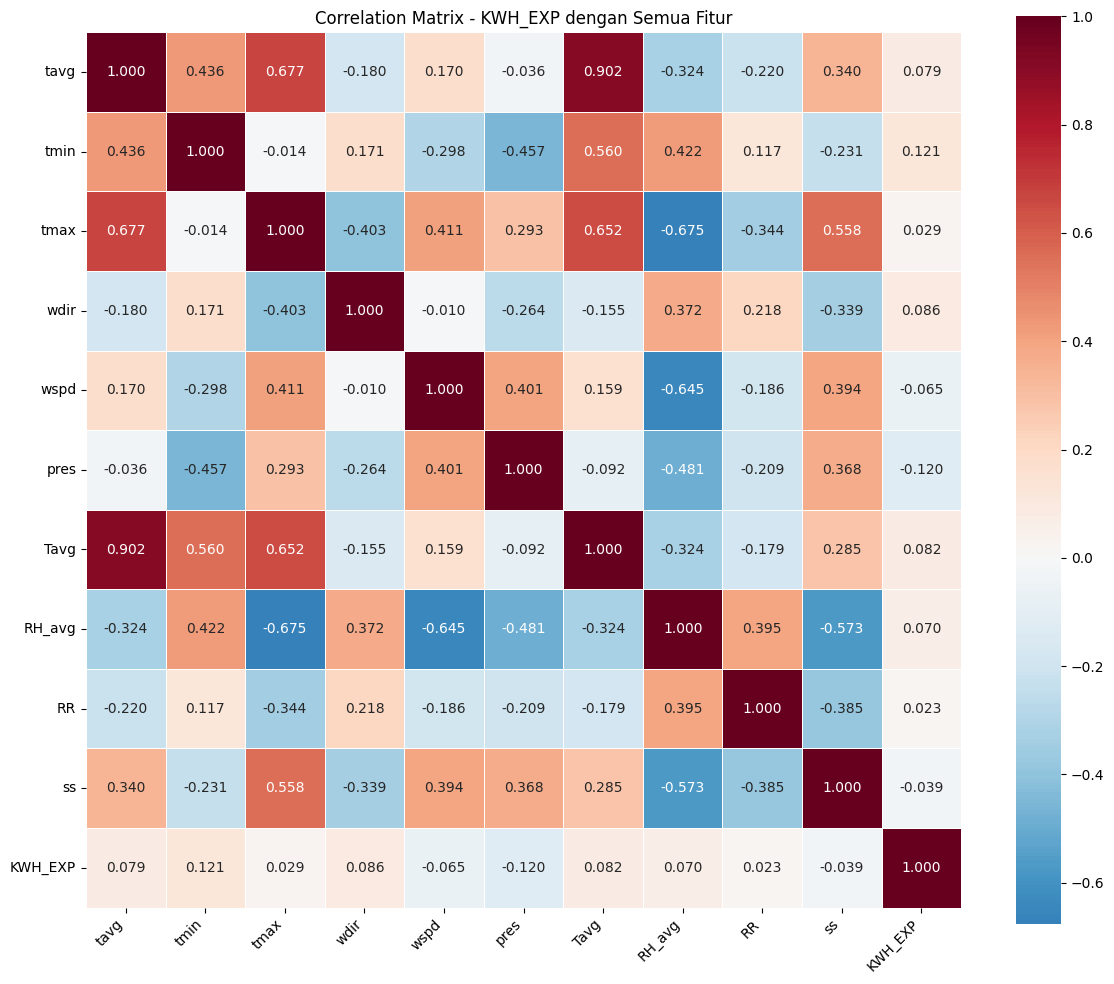

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_data, annot=True, cmap='RdBu_r', center=0, 
            square=True, linewidths=0.5, fmt='.3f')
plt.title('Correlation Matrix - KWH_EXP dengan Semua Fitur')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

=== UJI LINEARITAS DETAIL ===

Testing: tmin


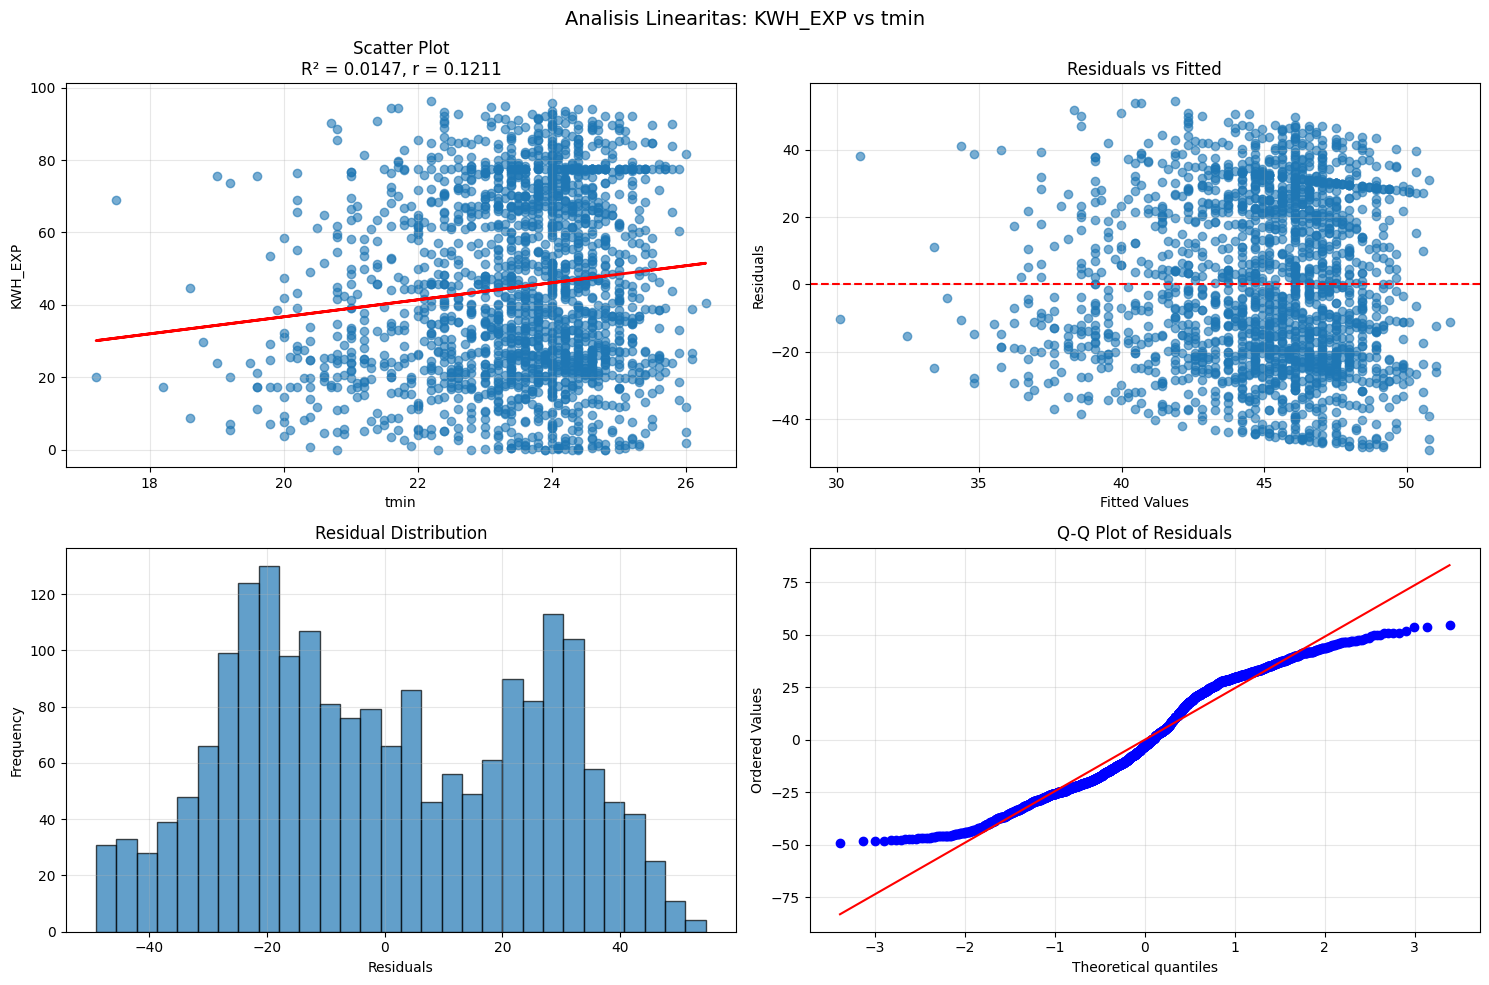

--------------------------------------------------------------------------------
Testing: pres


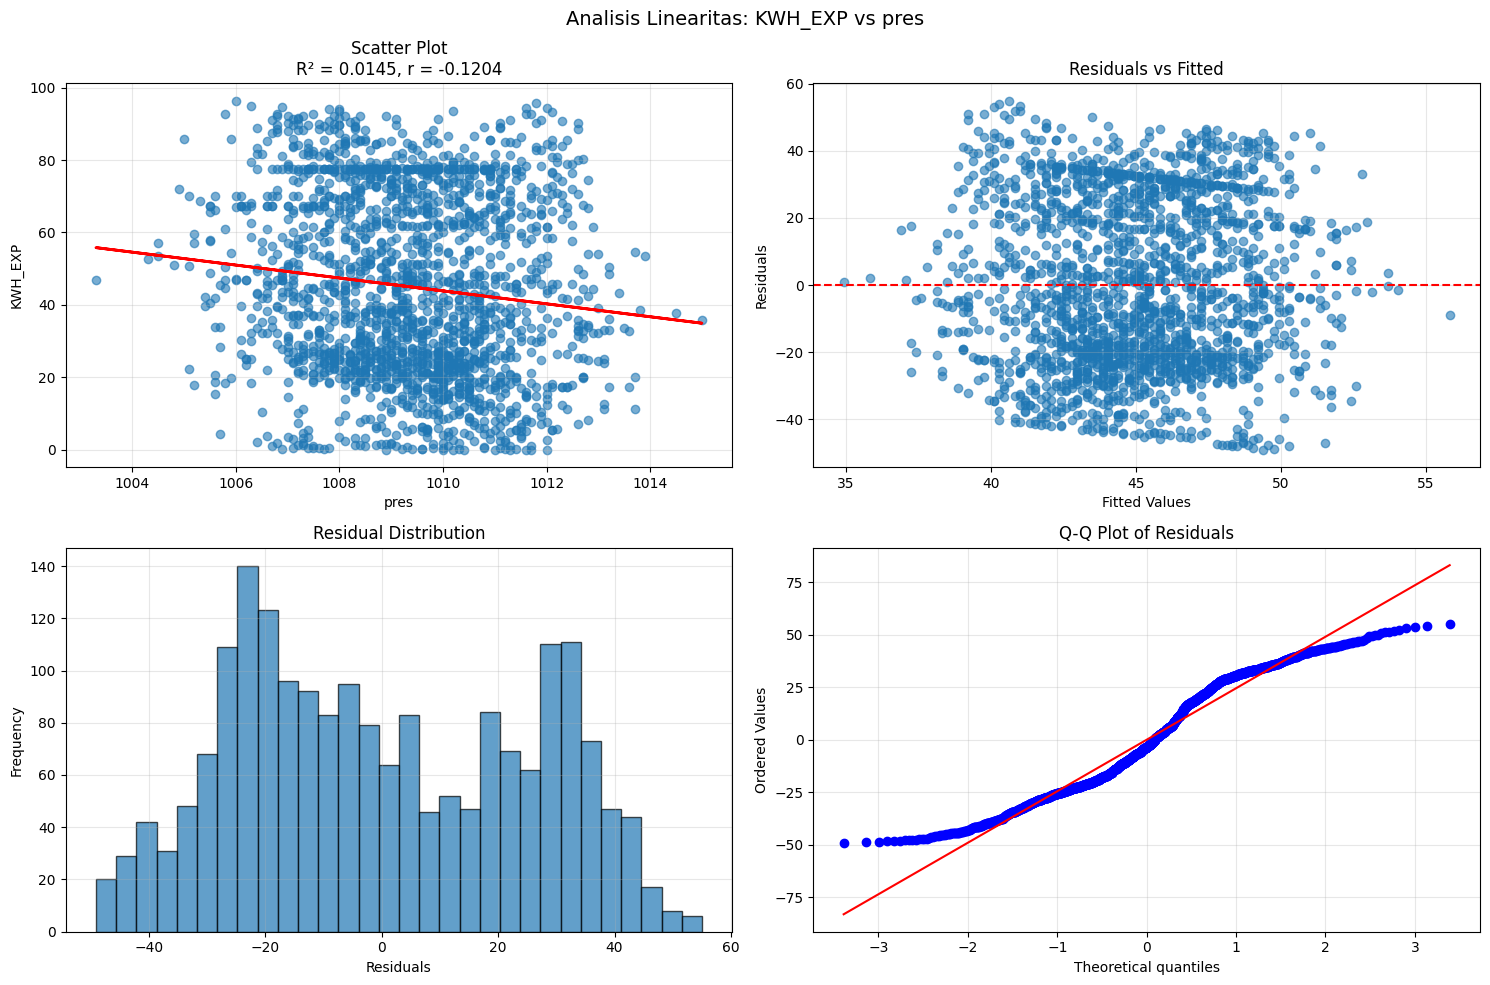

--------------------------------------------------------------------------------
Testing: wdir


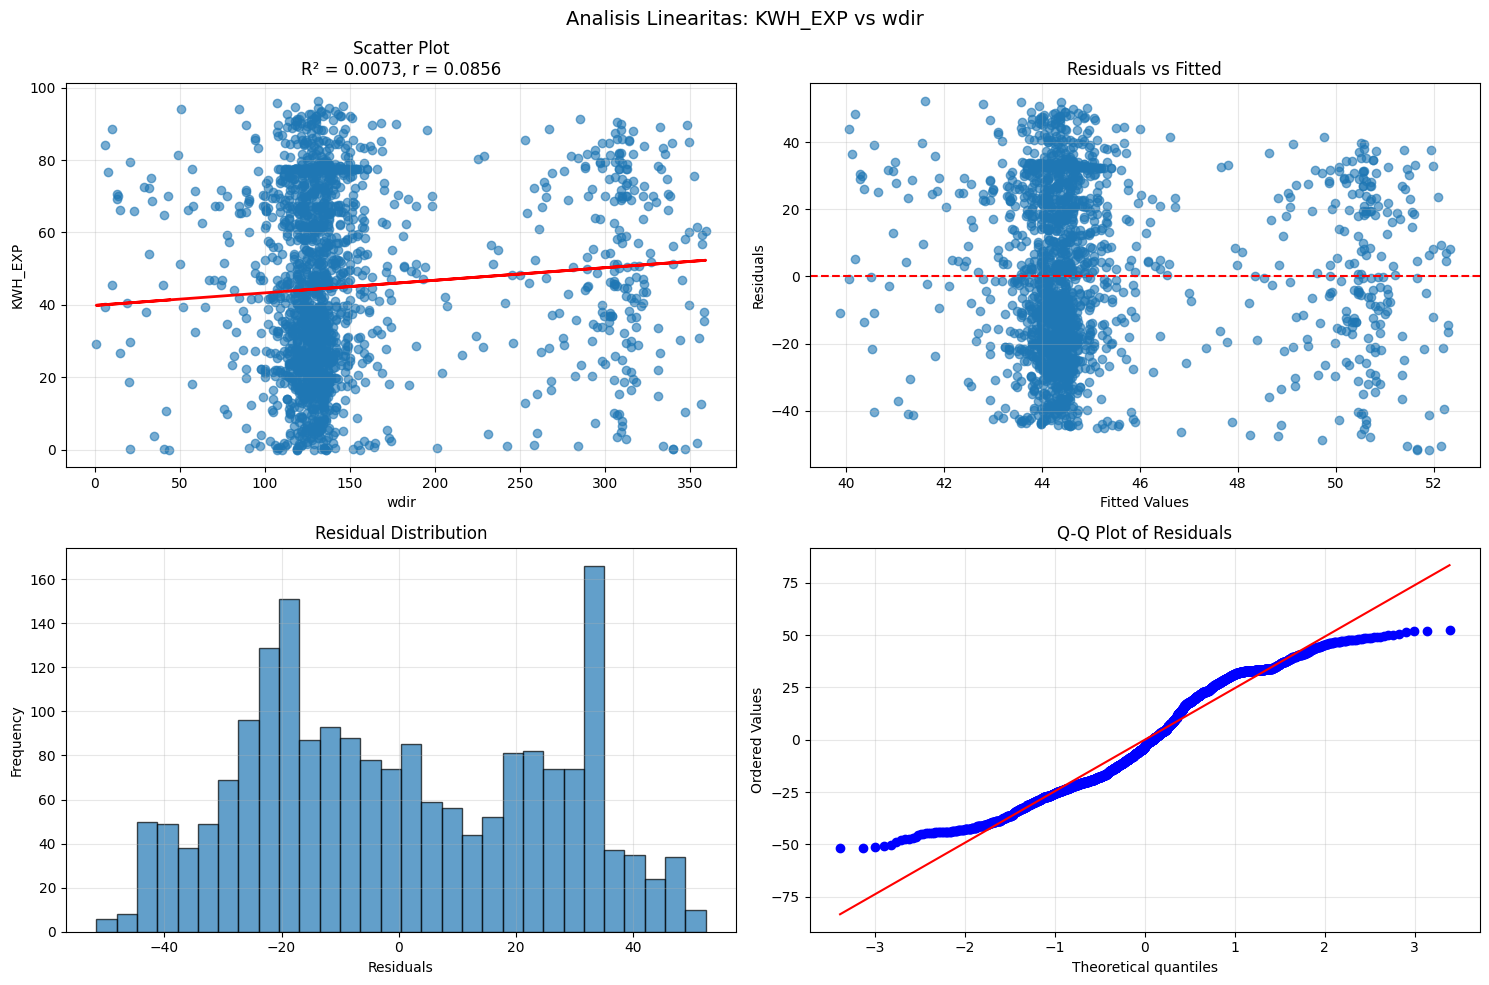

--------------------------------------------------------------------------------
Testing: Tavg


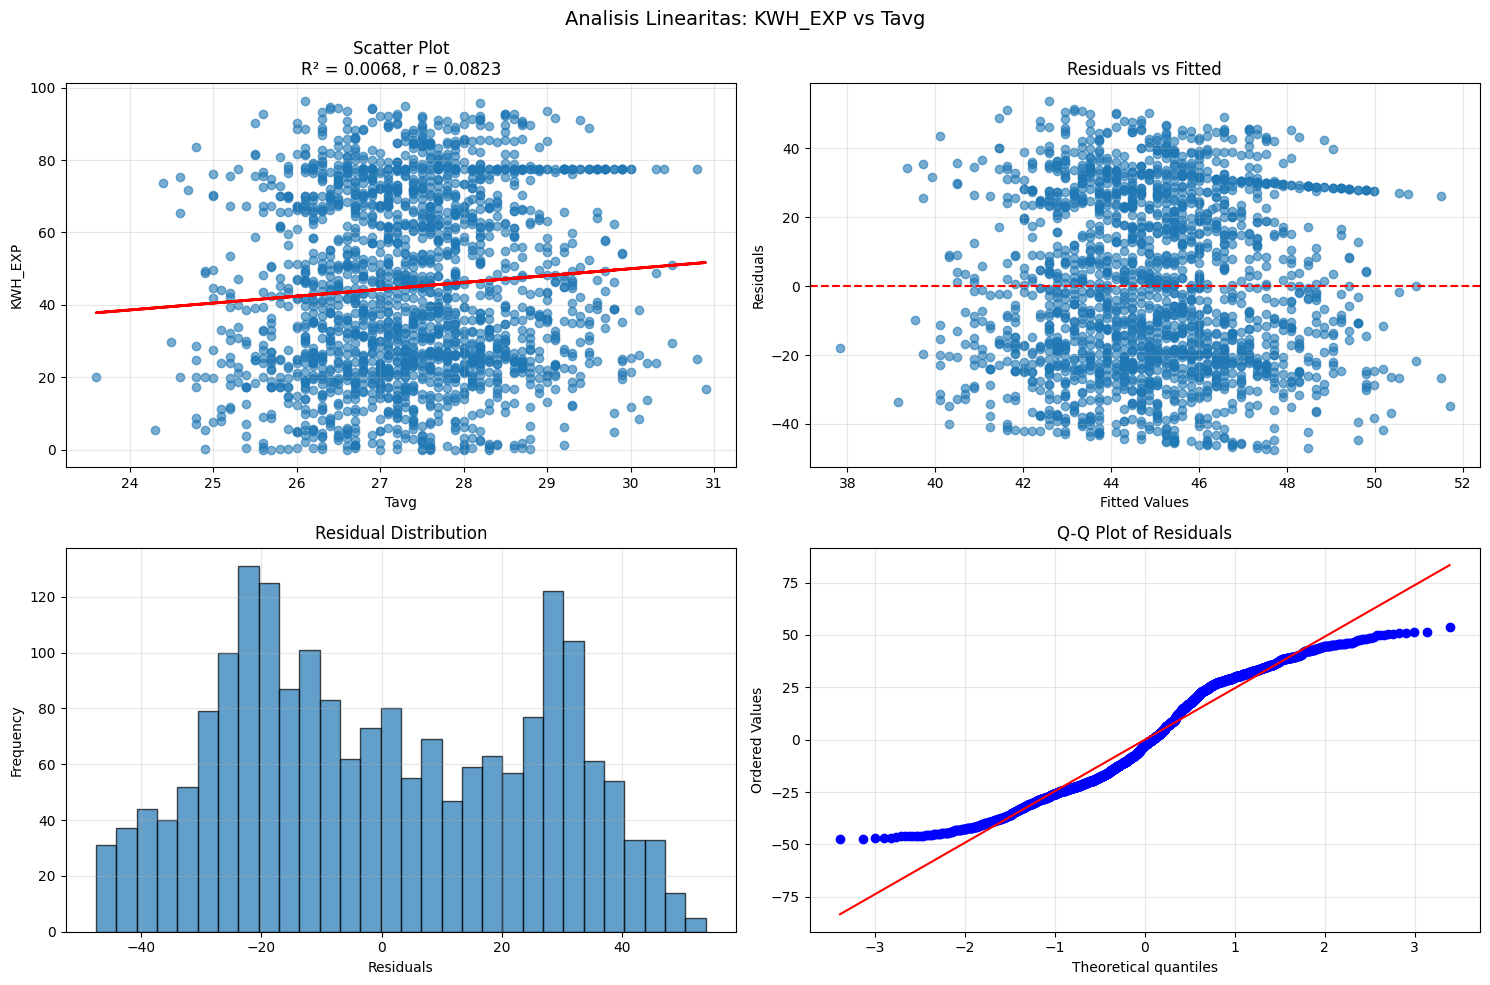

--------------------------------------------------------------------------------
Testing: tavg


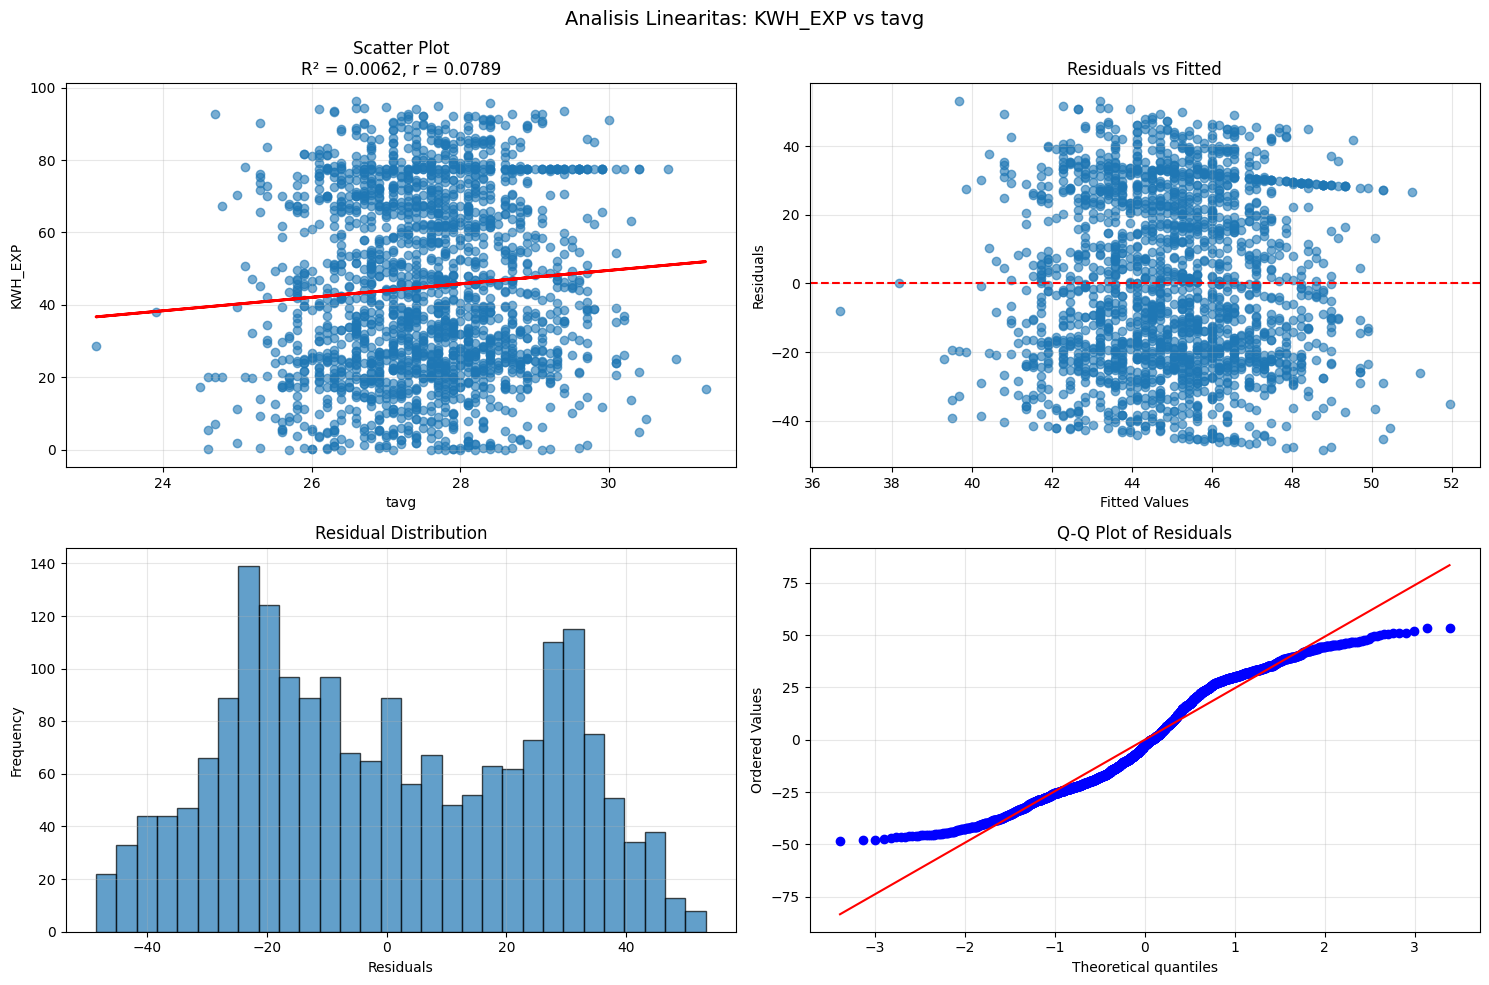

--------------------------------------------------------------------------------
Testing: RH_avg


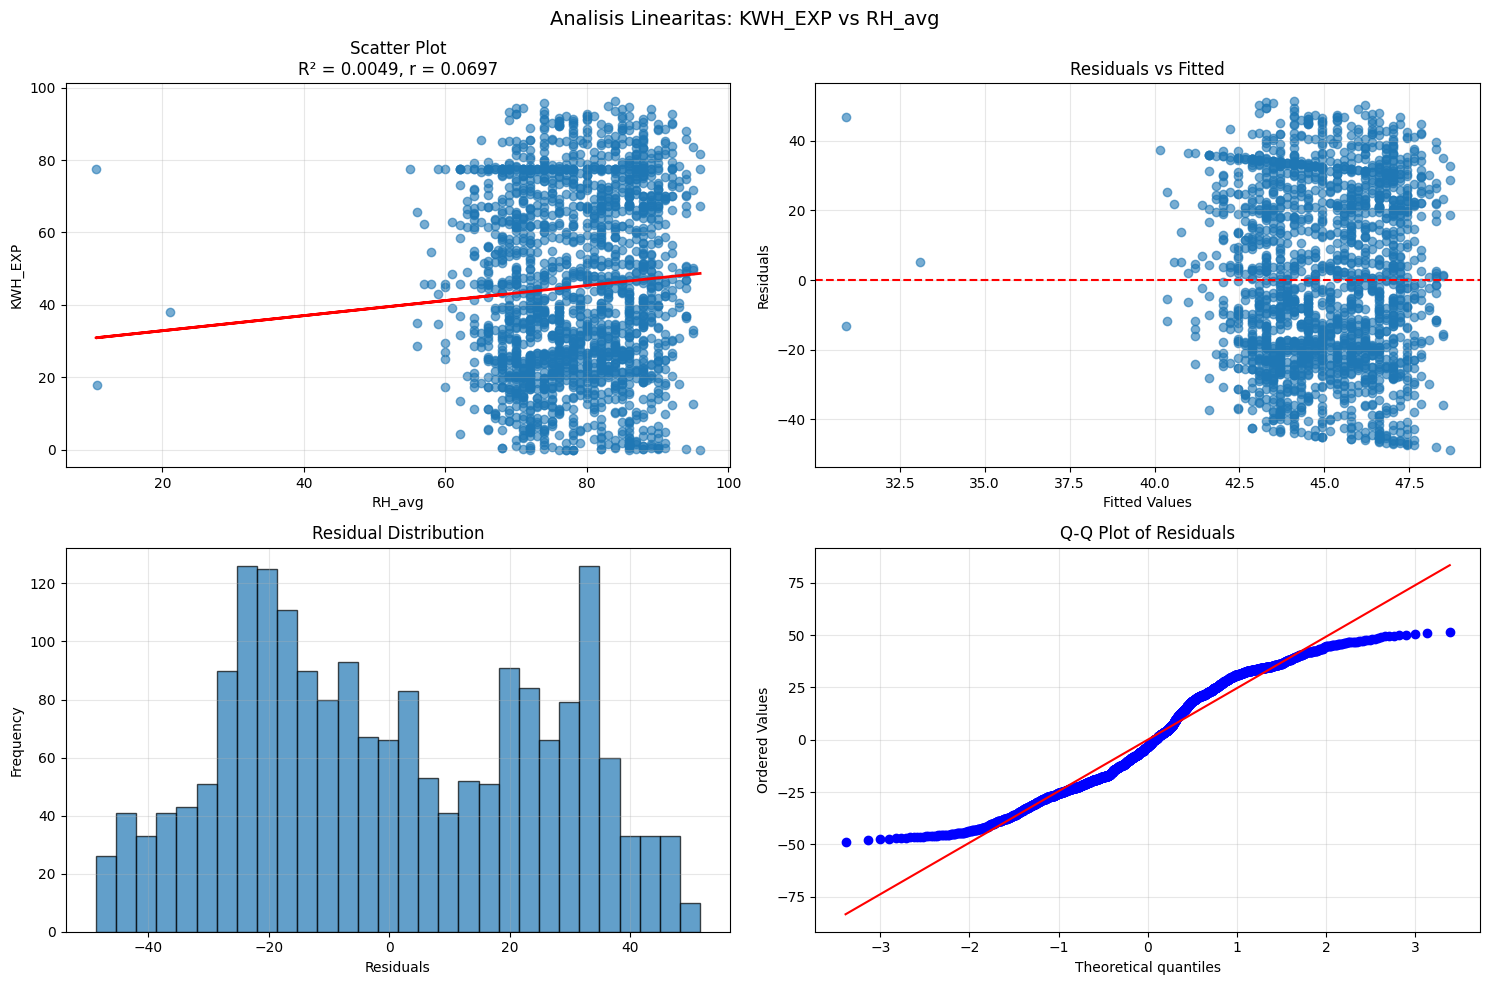

--------------------------------------------------------------------------------


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def detailed_linearity_test(X, y, feature_name):
    """
    Comprehensive linearity test dengan residual analysis
    """
    mask = ~(X.isna() | y.isna())
    X_clean = X[mask]
    y_clean = y[mask]
    
    if len(X_clean) < 5:
        print(f"Insufficient data for {feature_name}")
        return None, None
    
    model = LinearRegression()
    X_reshaped = X_clean.values.reshape(-1, 1)
    model.fit(X_reshaped, y_clean)
    
    y_pred = model.predict(X_reshaped)
    residuals = y_clean - y_pred
    
    r2 = r2_score(y_clean, y_pred)
    correlation = np.corrcoef(X_clean, y_clean)[0, 1]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Analisis Linearitas: KWH_EXP vs {feature_name}', fontsize=14)
    
    axes[0, 0].scatter(X_clean, y_clean, alpha=0.6)
    axes[0, 0].plot(X_clean, y_pred, 'r-', linewidth=2)
    axes[0, 0].set_xlabel(feature_name)
    axes[0, 0].set_ylabel('KWH_EXP')
    axes[0, 0].set_title(f'Scatter Plot\nR² = {r2:.4f}, r = {correlation:.4f}')
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].scatter(y_pred, residuals, alpha=0.6)
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_xlabel('Fitted Values')
    axes[0, 1].set_ylabel('Residuals')
    axes[0, 1].set_title('Residuals vs Fitted')
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    axes[1, 0].set_xlabel('Residuals')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Residual Distribution')
    axes[1, 0].grid(True, alpha=0.3)
    
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot of Residuals')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return r2, correlation

print("=== UJI LINEARITAS DETAIL ===\n")
top_features = kwh_correlations.head(6).index.tolist()

linearity_results = {}
for feature in top_features:
    print(f"Testing: {feature}")
    r2, corr = detailed_linearity_test(df[feature], df[target_col], feature)
    if r2 is not None:
        linearity_results[feature] = {'r2': r2, 'correlation': corr}
    print("-" * 80)

In [ ]:
def rainbow_test_kwh(X, y, feature_name):
    """
    Rainbow test untuk mendeteksi non-linearitas
    """
    mask = ~(X.isna() | y.isna())
    X_clean = X[mask]
    y_clean = y[mask]
    
    if len(X_clean) < 10:
        return None
    
    sorted_indices = np.argsort(X_clean)
    X_sorted = X_clean.iloc[sorted_indices]
    y_sorted = y_clean.iloc[sorted_indices]
    
    n = len(X_sorted)
    
    n1 = int(0.2 * n)
    n2 = int(0.8 * n)
    
    X_full = X_sorted.values.reshape(-1, 1)
    model_full = LinearRegression().fit(X_full, y_sorted)
    y_pred_full = model_full.predict(X_full)
    rss_full = np.sum((y_sorted - y_pred_full) ** 2)
    
    X_outer = np.concatenate([X_sorted[:n1].values, X_sorted[n2:].values]).reshape(-1, 1)
    y_outer = pd.concat([y_sorted[:n1], y_sorted[n2:]])
    model_outer = LinearRegression().fit(X_outer, y_outer)
    y_pred_outer = model_outer.predict(X_full)
    rss_outer = np.sum((y_sorted - y_pred_outer) ** 2)
    
    if rss_full > 0:
        rainbow_stat = (rss_outer - rss_full) / rss_full * (n - 2)
    else:
        rainbow_stat = 0
    
    return rainbow_stat

print("=== RAINBOW TEST (Non-linearity Detection) ===\n")
for feature in top_features[:5]:
    rainbow_stat = rainbow_test_kwh(df[feature], df[target_col], feature)
    if rainbow_stat is not None:
        if rainbow_stat > 3.84:
            conclusion = "NON-LINEAR (p < 0.05)"
        else:
            conclusion = "LINEAR (p >= 0.05)"
        print(f"{feature:15}: Rainbow = {rainbow_stat:8.4f} -> {conclusion}")
    else:
        print(f"{feature:15}: Insufficient data")

=== RAINBOW TEST (Non-linearity Detection) ===

tmin           : Rainbow =  13.5729 -> NON-LINEAR (p < 0.05)
pres           : Rainbow =  17.6547 -> NON-LINEAR (p < 0.05)
wdir           : Rainbow =  22.8455 -> NON-LINEAR (p < 0.05)
Tavg           : Rainbow =   9.8399 -> NON-LINEAR (p < 0.05)
tavg           : Rainbow =   3.8151 -> LINEAR (p >= 0.05)


In [ ]:
print("=" * 80)
print("                    RINGKASAN UJI LINEARITAS KWH_EXP")
print("=" * 80)

print(f"\n📊 RANKING BERDASARKAN KEKUATAN HUBUNGAN LINEAR:")
print("-" * 60)
if linearity_results:
    sorted_results = sorted(linearity_results.items(), key=lambda x: x[1]['r2'], reverse=True)
    for i, (feature, metrics) in enumerate(sorted_results, 1):
        r2 = metrics['r2']
        corr = metrics['correlation']
        
        # Interpretasi
        if r2 > 0.7:
            strength = "SANGAT KUAT"
        elif r2 > 0.5:
            strength = "KUAT"
        elif r2 > 0.3:
            strength = "SEDANG"
        elif r2 > 0.1:
            strength = "LEMAH"
        else:
            strength = "SANGAT LEMAH"
            
        print(f"{i:2}. {feature:15} | R² = {r2:6.4f} | r = {corr:7.4f} | {strength}")

print(f"\n📈 INTERPRETASI:")
print("   • R² > 0.7  : Hubungan linear sangat kuat (>70% variasi dijelaskan)")
print("   • R² 0.5-0.7: Hubungan linear kuat (50-70% variasi dijelaskan)")
print("   • R² 0.3-0.5: Hubungan linear sedang (30-50% variasi dijelaskan)")
print("   • R² 0.1-0.3: Hubungan linear lemah (10-30% variasi dijelaskan)")
print("   • R² < 0.1  : Hubungan linear sangat lemah (<10% variasi dijelaskan)")

print(f"\n💡 REKOMENDASI:")
strong_features = [f for f, m in linearity_results.items() if m['r2'] > 0.3]
if strong_features:
    print(f"   ✅ Fitur dengan hubungan linear yang baik untuk model linear:")
    for feature in strong_features:
        print(f"      - {feature}")
else:
    print("   ⚠️  Tidak ada fitur dengan hubungan linear yang kuat")
    print("      Pertimbangkan transformasi fitur atau model non-linear")

                    RINGKASAN UJI LINEARITAS KWH_EXP

📊 RANKING BERDASARKAN KEKUATAN HUBUNGAN LINEAR:
------------------------------------------------------------
 1. tmin            | R² = 0.0147 | r =  0.1211 | SANGAT LEMAH
 2. pres            | R² = 0.0145 | r = -0.1204 | SANGAT LEMAH
 3. wdir            | R² = 0.0073 | r =  0.0856 | SANGAT LEMAH
 4. Tavg            | R² = 0.0068 | r =  0.0823 | SANGAT LEMAH
 5. tavg            | R² = 0.0062 | r =  0.0789 | SANGAT LEMAH
 6. RH_avg          | R² = 0.0049 | r =  0.0697 | SANGAT LEMAH

📈 INTERPRETASI:
   • R² > 0.7  : Hubungan linear sangat kuat (>70% variasi dijelaskan)
   • R² 0.5-0.7: Hubungan linear kuat (50-70% variasi dijelaskan)
   • R² 0.3-0.5: Hubungan linear sedang (30-50% variasi dijelaskan)
   • R² 0.1-0.3: Hubungan linear lemah (10-30% variasi dijelaskan)
   • R² < 0.1  : Hubungan linear sangat lemah (<10% variasi dijelaskan)

💡 REKOMENDASI:
   ⚠️  Tidak ada fitur dengan hubungan linear yang kuat
      Pertimbangkan transf